In [7]:
from typing import Tuple, List, Union, Any, Optional, Dict, Literal, Callable
import time
import collections
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor, tensor
import pandas as pd
import openml


from optuna_kfoldCV import evaluate_dataset_with_model, run_all_openML_with_model
from classification_param_specs import evaluate_LogisticRegression, evaluate_XGBoostClassifier

np.set_printoptions(precision=3, threshold=5) # Print options

# How to run an experiment

In [8]:
# !python classification_param_specs.py \
#     --models LogisticRegression \
#     --dataset_indices 0 1 2 \
#     --save_dir /home/USERNAME/Code/RFRBoost-sup-mat/save/OpenMLClassification/ \
#     --n_optuna_trials 100 \
#     --device cpu \
#     --k_folds 5 \
#     --cv_seed 42

# join json results

In [9]:
from pydantic.v1.utils import deep_update
import json
import os
import numpy as np
import pandas as pd

from optuna_kfoldCV import openML_cls_ids


def read_json(path):
    with open(path, "r") as f:
        return json.load(f)
    


def custom_deep_update(original, update):
    for key, value in update.items():
        if isinstance(value, dict) and key in original:
            custom_deep_update(original[key], value)
        else:
            original[key] = value



def get_joined_results_json(
        models = ["End2End", "Ridge", "XGBoostRegressor",
                  "GradientRFRBoost", "GradientRFRBoostID", 
                  "GreedyRFRBoostDense", "GreedyRFRBoostDiag", "GreedyRFRBoostScalar",
                  "RandomFeatureNetwork"],
        datasets = openML_cls_ids,
        save_dir = "/home/USERNAME/Code/RFRBoost-sup-mat/save/OpenMLClassification/",
        classification_or_regression = "classification",
        ):
    results_json = {}
    for model in models:
        for dataset in datasets:
            path = os.path.join(save_dir, f"{classification_or_regression}_{dataset}_{model}.json")
            res = read_json(path)
            if results_json == {}:
                results_json = res
            else:
                custom_deep_update(results_json, res)
    return results_json



def join_jsons_into_array(
        results_json,
        ):
    results = []
    for dataset, dataset_results in results_json.items():
        res = []
        for model_name, model_results in dataset_results.items():
            model_res = np.stack([model_results["score_train"], model_results["score_test"], model_results["t_fit"], model_results["t_inference"]])
            res.append(model_res)
        results.append(res)
    return np.stack(results) # (n_datasets, n_models, 4, n_folds)


def results_to_df(
        models = ["End2End", "Ridge", "XGBoostRegressor", 
                  "GradientRFRBoost", "GradientRFRBoostID", 
                  "GradientRFRBoost_relu",
                  "GreedyRFRBoostDense", "GreedyRFRBoostDiag", "GreedyRFRBoostScalar",
                  "GreedyRFRBoostDense_relu", "GreedyRFRBoostDiag_relu", "GreedyRFRBoostScalar_relu",
                  "RandomFeatureNetwork", "RandomFeatureNetwork_iid",
                  "RandomFeatureNetwork_relu", "RandomFeatureNetwork_iid_relu",
                  ],
        datasets = openML_cls_ids[:],
        save_dir = "/home/USERNAME/Code/RFRBoost-sup-mat/save/OpenMLClassification/",
        keep_individual_folds = False,
        ):
    # Load and join the JSON data
    results_json = get_joined_results_json(models, datasets, save_dir)
    results = join_jsons_into_array(results_json) # (n_datasets, n_models, 4, n_folds)
    
    metrics = ["score_train", "score_test", "t_fit", "t_inference"]
    metric_dfs = {}
    
    if keep_individual_folds:
        n_folds = results.shape[-1]
        for metric in metrics:
            # Create indices like '3_1', '3_2', etc.
            indices = [f"{dataset}_{fold+1}" for dataset in datasets for fold in range(n_folds)]
            metric_dfs[metric] = pd.DataFrame(index=indices, columns=models)
            
            for dataset_idx, dataset in enumerate(datasets):
                for fold in range(n_folds):
                    for model_idx, model in enumerate(models):
                        value = results[dataset_idx, model_idx, metrics.index(metric), fold]
                        index = f"{dataset}_{fold+1}"
                        metric_dfs[metric].loc[index, model] = value
    else:
        # Original behavior with means and stds
        results_mean = np.mean(results, axis=-1)
        results_std = np.std(results, axis=-1)
        
        for metric in metrics:
            metric_dfs[metric] = pd.DataFrame(index=datasets, columns=models)
            metric_dfs[f"{metric}_std"] = pd.DataFrame(index=datasets, columns=models)
        
        for dataset_idx, dataset in enumerate(datasets):
            for model_idx, model in enumerate(models):
                for metric_idx, metric in enumerate(metrics):
                    metric_dfs[metric].loc[dataset, model] = results_mean[dataset_idx, model_idx, metric_idx]
                    metric_dfs[f"{metric}_std"].loc[dataset, model] = results_std[dataset_idx, model_idx, metric_idx]
    
    return metric_dfs

In [18]:
save_dir = "/home/USERNAME/Code/RFRBoost-sup-mat/save/OpenMLClassification/"

In [11]:
df = results_to_df(        
    models = ["End2End_cpu", 
                "LogisticRegression", 
                "XGBoostClassifier", 
                "RFNN",
                "RFRBoost_ID_batchnormFalse",
                ],
    datasets = openML_cls_ids[[i for i in range(len(openML_cls_ids)) if i not in []]],
    save_dir=save_dir,
    keep_individual_folds=False,
    )

In [12]:
df["score_test"].mean().sort_values(ascending=True)

RFRBoost_ID_batchnormFalse   -0.853598
XGBoostClassifier            -0.852223
End2End_cpu                  -0.850486
RFNN                         -0.844792
LogisticRegression           -0.821484
dtype: object

In [13]:
df["t_fit"].mean().sort_values(ascending=True)

LogisticRegression             0.133748
RFNN                           1.022023
RFRBoost_ID_batchnormFalse     2.005622
XGBoostClassifier              3.695354
End2End_cpu                   30.517586
dtype: object

In [14]:
df["score_test"].rank(axis=1).mean().sort_values()

RFRBoost_ID_batchnormFalse    2.149123
End2End_cpu                   2.824561
XGBoostClassifier             2.850877
RFNN                          3.307018
LogisticRegression            3.868421
dtype: float64

# Print results

In [15]:
df_renamed = {k:v for k,v in df.items()}
print(df_renamed["score_test"].columns)
for key in df_renamed.keys():
    df_renamed[key] = df_renamed[key].rename(columns={
        "End2End_cpu": "E2E MLP ResNet",
        "LogisticRegression": "Logistic Regression",
        "XGBoostClassifier": "XGBoost",
        "RFRBoost_ID_batchnormFalse": "RFRBoost",
        "RFNN": "RFNN",
        })
print(df_renamed["score_test"].columns)

Index(['End2End_cpu', 'LogisticRegression', 'XGBoostClassifier', 'RFNN',
       'RFRBoost_ID_batchnormFalse'],
      dtype='object')
Index(['E2E MLP ResNet', 'Logistic Regression', 'XGBoost', 'RFNN', 'RFRBoost'], dtype='object')


/tmp/ipykernel_17483/3529910158.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


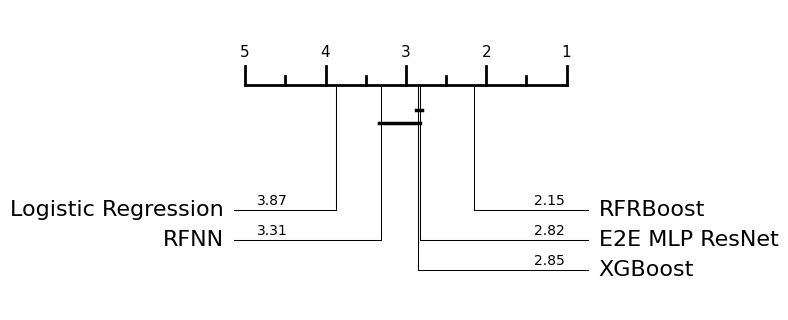

In [16]:
from aeon.visualisation import plot_critical_difference, plot_significance
import matplotlib.pyplot as plt

# Generate the plot
plot = plot_critical_difference(df_renamed["score_test"].values,
                                df_renamed["score_test"].columns.tolist(), 
                                alpha=0.10, 
                                lower_better=True,
                                digits=2,
                                width=7, #default 6
                                textspace=2.0, #default 1.5
                                )

# Retrieve the figure and axes from the plot
fig = plot[0].figure
ax = plot[0]

# Adjust figure size
fig.set_size_inches(6, 3)

# Adjust layout
fig.tight_layout()

# Save the figures
plot[0].savefig("results/OpenMLClassification/OpenMLCls_critical_difference.eps", bbox_inches='tight')
plot[0].savefig("results/OpenMLClassification/OpenMLCls_critical_difference.png", bbox_inches='tight')

In [17]:
import pandas as pd
import numpy as np

def create_latex_table(
        df_scores: pd.DataFrame, 
        df_t_fit: pd.DataFrame, 
        decimals: int = 3, 
        include_std: bool = False) -> str:
    table = """\\begin{table}[t]
\\caption{Average test accuracies and fit times on the OpenML classification tasks.}
\\label{tab:openml-classification}
\\vskip 0.15in
\\begin{center}
\\begin{small}
\\begin{sc}
\\begin{tabular}{lcc}
\\toprule
Model & Acc & Fit Time (s) \\\\
\\midrule
"""
    # Calculate means and stds
    score_means = df_scores.mean()
    score_stds = df_scores.std()
    time_means = df_t_fit.mean()
    time_stds = df_t_fit.std()
    
    # Create sorted index based on scores
    sorted_idx = score_means.sort_values(ascending=False).index
    
    # Create formatted rows
    for model in sorted_idx:
        if include_std:
            score_str = f"{score_means[model]:.{decimals}f} ({score_stds[model]:.{decimals}f})"
            time_str = f"{time_means[model]:.{decimals}f} ({time_stds[model]:.{decimals}f})"
        else:
            score_str = f"{score_means[model]:.{decimals}f}"
            time_str = f"{time_means[model]:.{decimals}f}"
        table += f"{model} & {score_str} & {time_str} \\\\\n"
    
    table += """\\bottomrule
\\end{tabular}
\\end{sc}
\\end{small}
\\end{center}
\\vskip -0.1in
\\end{table}
"""
    return table


#usage
latex_table = create_latex_table(-df_renamed["score_test"], df_renamed["t_fit"])
print(latex_table)

\begin{table}[t]
\caption{Average test accuracies and fit times on the OpenML classification tasks.}
\label{tab:openml-classification}
\vskip 0.15in
\begin{center}
\begin{small}
\begin{sc}
\begin{tabular}{lcc}
\toprule
Model & Acc & Fit Time (s) \\
\midrule
RFRBoost & 0.854 & 2.006 \\
XGBoost & 0.852 & 3.695 \\
E2E MLP ResNet & 0.850 & 30.518 \\
RFNN & 0.845 & 1.022 \\
Logistic Regression & 0.821 & 0.134 \\
\bottomrule
\end{tabular}
\end{sc}
\end{small}
\end{center}
\vskip -0.1in
\end{table}

